In [1]:
import glob
import os
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from tensorflow.keras.utils import to_categorical
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from livelossplot.inputs.tf_keras import PlotLossesCallback
from sklearn import metrics 
from keras.utils import np_utils
from sklearn.metrics import roc_curve, auc, confusion_matrix
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# constants
DROPOUT= 0.5
EPOCHS=20
BATCH_SIZE = 24
ACTIVATION_FUNCTION = 'relu'
OPTIMIZER='Adamax'
DATA_DIR = "data_us8k_numpy"
LABELS = ["aircon","horn","child","dog","drill","engine","gun","hammer","siren","music"]
SOUND_FILE_PATHS = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
SOUND_NAMES = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
PARENT_DIR = 'samples/'

In [3]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def add_folds():
    subsequent_fold = False
    for k in range(1,9):
        fold_name = 'fold' + str(k)
        feature_file = os.path.join(DATA_DIR, fold_name + '_x.npy')
        labels_file = os.path.join(DATA_DIR, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels

x_train, y_train = add_folds()

# use a fold for validation
valid_fold_name = 'fold9'
feature_file = os.path.join(DATA_DIR, valid_fold_name + '_x.npy')
labels_file = os.path.join(DATA_DIR, valid_fold_name + '_y.npy')
x_val = np.load(feature_file)
y_val = np.load(labels_file) 

# and a fold for testing
test_fold_name = 'fold10'
feature_file = os.path.join(DATA_DIR, test_fold_name + '_x.npy')
labels_file = os.path.join(DATA_DIR, test_fold_name + '_y.npy')
x_test = np.load(feature_file)
y_test = np.load(labels_file)

print ("\nTraining Set Features:", x_train.shape, "Labels:", y_train.shape)
print ("Validation Set Features:", x_val.shape, "Labels:", y_val.shape)
print ("Test Set Features:", x_test.shape, "Labels:", y_test.shape)



Training Set Features: (7077, 193) Labels: (7077, 10)
Validation Set Features: (816, 193) Labels: (816, 10)
Test Set Features: (837, 193) Labels: (837, 10)


In [5]:
# neural network dimensions
n_dim = x_train.shape[1]
n_classes = y_train.shape[1]
print ("Features:", n_dim, "Classes:", n_classes)

Features: 193 Classes: 10


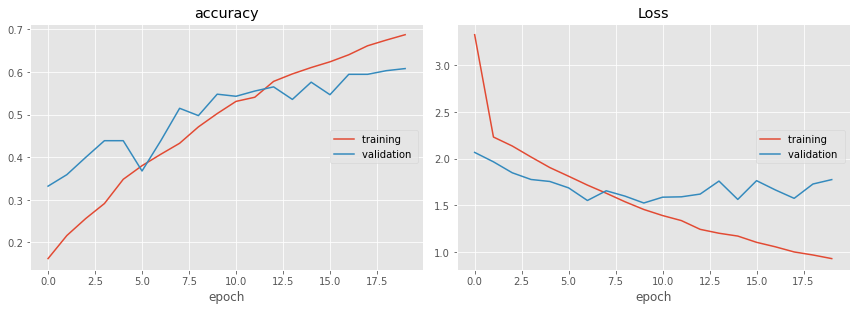

accuracy
	training         	 (min:    0.157, max:    0.687, cur:    0.687)
	validation       	 (min:    0.228, max:    0.608, cur:    0.608)
Loss
	training         	 (min:    0.929, max:    6.070, cur:    0.929)
	validation       	 (min:    1.351, max:    2.132, cur:    1.776)
295/295 [==============================] - 7s 24ms/step - loss: 0.9289 - accuracy: 0.6873 - val_loss: 1.7757 - val_accuracy: 0.6078
Scores:  [1.5653949975967407, 0.5185185074806213]
Erro modelo: 48.15%


In [17]:
tf.random.set_seed(0)
np.random.seed(0)

def create_model():
    model = Sequential()
    # layer 1
    model.add(Dense(n_dim, input_dim=n_dim, activation=ACTIVATION_FUNCTION))
    # layer 2
    model.add(Dense(400, activation=ACTIVATION_FUNCTION))
    #model.add(Dropout(DROPOUT))
    # layer 3
    model.add(Dense(200, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # layer 3
    model.add(Dense(100, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
    return model

model = create_model()

earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[PlotLossesCallback()])

# Avaliação final com os casos de teste
scores = model.evaluate(x_test, y_test, verbose=0)
print('Scores: ', scores)
print("Erro modelo: %.2f%%" % (100-scores[1]*100))


In [18]:
# obtain the prediction probabilities
y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, 1)

<AxesSubplot:>

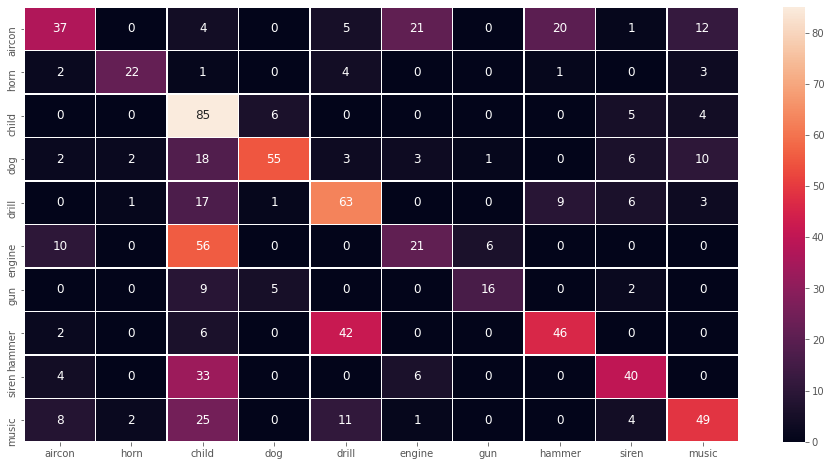

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (16,8))
sns.heatmap(cm,annot=True,xticklabels=LABELS,yticklabels=LABELS, annot_kws={"size": 12}, fmt='g', linewidths=.5)

In [20]:
def predict_sound(sound_file_path):
    predict_file = sound_file_path
    predict_x = extract_features(predict_file)

    prediction = model.predict(predict_x)

    ind = np.argpartition(prediction[0], -2)[-2:]
    ind[np.argsort(prediction[0][ind])]
    ind = ind[::-1]

    print ("Top guess: ", SOUND_NAMES[ind[0]], " (",round(prediction[0,ind[0]],3),")")
    print ("2nd guess: ", SOUND_NAMES[ind[1]], " (",round(prediction[0,ind[1]],3),")")
    
def extract_features(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

for s in range(len(SOUND_NAMES)):

    print ("\n----- ", SOUND_NAMES[s], "-----")
    # load audio file and extract features
    predict_file = PARENT_DIR + SOUND_FILE_PATHS[s]
    predict_x = extract_features(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    if len(predictions) == 0: 
        print ("No prediction")
        continue
    
 
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print ("Top guess: ", SOUND_NAMES[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    print ("2nd guess: ", SOUND_NAMES[ind[1]], " (",round(predictions[0,ind[1]],3),")")


-----  air conditioner -----
Top guess:  air conditioner  ( 0.293 )
2nd guess:  children playing  ( 0.203 )

-----  car horn -----
Top guess:  car horn  ( 0.994 )
2nd guess:  street music  ( 0.003 )

-----  children playing -----
Top guess:  children playing  ( 0.439 )
2nd guess:  street music  ( 0.355 )

-----  dog bark -----
Top guess:  dog bark  ( 0.801 )
2nd guess:  children playing  ( 0.089 )

-----  drilling -----
Top guess:  drilling  ( 1.0 )
2nd guess:  jackhammer  ( 0.0 )

-----  engine idling -----
Top guess:  engine idling  ( 0.991 )
2nd guess:  air conditioner  ( 0.006 )

-----  gun shot -----
Top guess:  gun shot  ( 0.874 )
2nd guess:  dog bark  ( 0.046 )

-----  jackhammer -----
Top guess:  jackhammer  ( 0.499 )
2nd guess:  engine idling  ( 0.17 )

-----  siren -----
Top guess:  siren  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )

-----  street music -----
Top guess:  street music  ( 0.998 )
2nd guess:  drilling  ( 0.001 )


In [21]:
predict_sound('soundSamples/kids.wav')

Top guess:  children playing  ( 0.266 )
2nd guess:  air conditioner  ( 0.17 )


In [22]:
predict_sound('soundSamples/aircond.wav')

Top guess:  dog bark  ( 0.318 )
2nd guess:  siren  ( 0.177 )


In [23]:
predict_sound('soundSamples/music.wav')

Top guess:  street music  ( 1.0 )
2nd guess:  drilling  ( 0.0 )


In [24]:
predict_sound('soundSamples/traffic.wav')

Top guess:  street music  ( 0.249 )
2nd guess:  drilling  ( 0.208 )


In [25]:
predict_sound('soundSamples/jackhammer.wav')

Top guess:  drilling  ( 0.997 )
2nd guess:  street music  ( 0.002 )


In [26]:
predict_sound('soundSamples/gun.wav')

Top guess:  gun shot  ( 0.968 )
2nd guess:  dog bark  ( 0.016 )


In [27]:
predict_sound('soundSamples/car.wav')

Top guess:  children playing  ( 0.337 )
2nd guess:  engine idling  ( 0.189 )


In [30]:
y_predict = model.predict(x_test)
preds = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [32]:
def print_series_prediction(y_test,predic):
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        print('y_test:',y_test[i], 'Previsão:',predic[i])
        
print_series_prediction(y_test, preds)

y_test: 1 Previsão: 9
y_test: 5 Previsão: 2
y_test: 3 Previsão: 9
y_test: 9 Previsão: 9
y_test: 4 Previsão: 4
y_test: 3 Previsão: 3
y_test: 4 Previsão: 4
y_test: 9 Previsão: 9
y_test: 5 Previsão: 0
y_test: 4 Previsão: 4
y_test: 8 Previsão: 2
y_test: 8 Previsão: 8
y_test: 8 Previsão: 8
y_test: 2 Previsão: 2
y_test: 2 Previsão: 2
y_test: 1 Previsão: 9
y_test: 2 Previsão: 2
y_test: 4 Previsão: 4
y_test: 3 Previsão: 2
y_test: 8 Previsão: 8
y_test: 2 Previsão: 2
y_test: 4 Previsão: 4
y_test: 0 Previsão: 7
y_test: 6 Previsão: 2
y_test: 2 Previsão: 2
y_test: 1 Previsão: 1
y_test: 9 Previsão: 9
y_test: 3 Previsão: 9
y_test: 0 Previsão: 9
y_test: 2 Previsão: 2
y_test: 3 Previsão: 3
y_test: 8 Previsão: 8
y_test: 9 Previsão: 9
y_test: 5 Previsão: 2
y_test: 0 Previsão: 5
y_test: 2 Previsão: 2
y_test: 7 Previsão: 7
y_test: 7 Previsão: 4
y_test: 4 Previsão: 4
y_test: 9 Previsão: 0
y_test: 2 Previsão: 9
y_test: 7 Previsão: 7
y_test: 0 Previsão: 5
y_test: 5 Previsão: 2
y_test: 5 Previsão: 2
y_test: 6 